In [3]:
# import all needed libraries
import dotenv
import urllib.request
import urllib.parse
import requests
import re
import pandas as pd
import numpy as np
import json
import os
from tqdm import tqdm
dotenv.load_dotenv()

True

### Step 1: Load gen-level data from 2022, keep only the required fields, and drop duplicates
- Create new df with plant_name, plant_code, county, state, capacity, and tech_type
- Drop duplicates at generator level for now
- Sample 25 projects, with an random distribution from capacity 5 to max(capacity)
- Export CSV

In [31]:
gen_2022 = pd.read_csv('opgen_2022.csv', header=2)
# drop 'Plant Code' with NaN or inf
gen_2022 = gen_2022.dropna(subset=['Plant Code'])
df = pd.DataFrame()
df['plant_name'] = gen_2022['Plant Name']
# get df['plant_code'] from gen_2022['Plant Code'] as dtype int
df['plant_code'] = gen_2022['Plant Code'].astype(int)
df = df.dropna(subset=['plant_code'])
df['county'] = gen_2022['County']
df['state'] = gen_2022['State']
df['capacity'] = gen_2022['Nameplate Capacity (MW)']
df['capacity'] = df['capacity'].str.replace(',', '').replace(' ', np.nan).astype(float)
df['tech_type'] = gen_2022['Prime Mover']
df['op_year'] = gen_2022['Operating Year']

df = df.drop_duplicates(subset=['plant_code'])
df = df[(df['tech_type'] == 'WT') | (df['tech_type'] == 'PV')]
# reset index
df = df.reset_index(drop=True)
# Get random sample of 25 rows with even distribution of capacity and tech_type
df = df.sample(n=25, weights='capacity', random_state=1)
# reset index
df = df.reset_index(drop=True)
df.head()
# save df to csv
df.to_csv('sample_25.csv', index=False)

/var/folders/m5/0x0gwbxx1kz02qrmghysp2mw0000gn/T/ipykernel_11494/1593348493.py:1: DtypeWarning: Columns (0,15,17,18,25,26,35,36,37,38,40,41,42,51,52,53,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  gen_2022 = pd.read_csv('opgen_2022.csv', header=2)


### Step 2: Search engine results
- Add column called 'search_query' with formatted search query
- Get search results for each plant using brightdata API (append keywords), save JSON + new field called 'num_search_results' (0 if there are none)

In [32]:
def search_query(plant_name, county, state, prime_mover):
    """ This function takes in the Plant Name, County, State, and Prime Mover and returns a web engine search query string with the Plant Name County State and "(controversy OR opposition OR lawsuit OR conflict OR hearing)"""
    # Make sure plant_name, county, state, and prime_mover are all strings
    plant_name = str(plant_name)
    county = str(county)
    state = str(state)
    prime_mover = str(prime_mover)
    # if the Prime Mover is "PV" and the Plant Name DOES NOT contain "solar" then add "solar" to the search query
    if prime_mover == "PV" and "solar" not in plant_name.lower():
        plant_name += " Solar"
    # If the Prime Mover is "WT" and the Plant Name DOES NOT contain "wind" then add "wind" to the search query
    if prime_mover == "WT" and "wind" not in plant_name.lower():
        plant_name += " Wind"
    #remove "LLC" from the plant name if it exists
    #plant_name = plant_name.replace("LLC", "")
    state = state.upper()
    # Use abbrev_to_us_state json file to convert state abbreviation to full state name
    with open('abbrev_to_us_state.json') as f:
        abbrev_to_us_state = json.load(f)
    state = abbrev_to_us_state[state]
    # create the search query
    search_query = f"{plant_name} {county} County {state} (controversy OR opposition OR lawsuit OR conflict OR hearing)"
    #remove quotation marks from the search query
    search_query = search_query.replace('"', "")
    return search_query

In [34]:
sample_25 = pd.read_csv('sample_25.csv')
sample_25['search_query'] = sample_25.apply(lambda x: search_query(x['plant_name'], x['county'], x['state'], x['tech_type']), axis=1)
# Rewrite CSV
sample_25.to_csv('sample_25.csv', index=False)

In [3]:
sample_25 = pd.read_csv('sample_25.csv')

In [6]:
sample_25['result'] = ''
for index, row in tqdm(sample_25.iterrows()):
    try: 
        if row['search_query'] != 'initial' or pd.isnull(row['result']):
            search = str(row['search_query'])

            opener = urllib.request.build_opener(
                urllib.request.ProxyHandler(
                    {'http': os.environ['BRIGHTDATA_SERP_KEY'],
                    'https': os.environ['BRIGHTDATA_SERP_KEY']}))
            search_query = urllib.parse.quote_plus(search)

            results = json.loads(opener.open(f'http://www.google.com/search?q={search_query}&brd_json=1').read())
            sample_25.at[index, 'result'] = json.dumps(results)
        else: pass
    except:
        sample_25.at[index, 'result'] = 'no results'


25it [01:37,  3.88s/it]


In [7]:
# for each row, load json and get length of results in ['organic'] then add int to new column 'num_results'. If 'no results' then add 0
sample_25['num_results'] = sample_25.apply(lambda x: len(json.loads(x['result'])['organic']) if x['result'] != 'no results' else 0, axis=1)
sample_25.head()

,plant_name,plant_code,county,state,capacity,tech_type,op_year,search_query,result,num_results
0,Old Mill Solar,59374,Klamath,OR,5.0,PV,2015,Old Mill Solar Klamath County Oregon (controve...,"{""general"": {""search_engine"": ""google"", ""langu...",10
1,Debary Solar Power Plant,62542,Volusia,FL,74.5,PV,2020,Debary Solar Power Plant Volusia County Florid...,"{""general"": {""search_engine"": ""google"", ""resul...",9
2,Medicine Bow,692,Carbon,WY,4.9,WT,2000,Medicine Bow Wind Carbon County Wyoming (contr...,"{""general"": {""search_engine"": ""google"", ""resul...",10
3,El Cabo Wind,58098,Torrance,NM,298.0,WT,2017,El Cabo Wind Torrance County New Mexico (contr...,"{""general"": {""search_engine"": ""google"", ""resul...",10
4,Oakfield Wind Project,57002,Aroostook,ME,148.0,WT,2015,Oakfield Wind Project Aroostook County Maine (...,"{""general"": {""search_engine"": ""google"", ""resul...",10


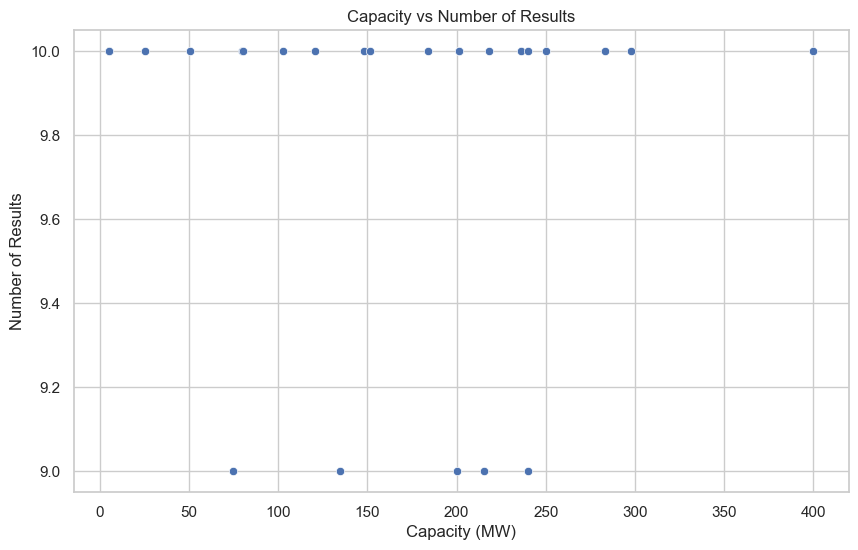

In [8]:
# Make a graph correlating capacity and num_results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_25, x='capacity', y='num_results')
plt.title('Capacity vs Number of Results')
plt.xlabel('Capacity (MW)')
plt.ylabel('Number of Results')
plt.show()

In [9]:
# Rewrite CSV
sample_25.to_csv('sample_25.csv', index=False)

### Step 3: Get content of each result (if num_results > 0) using unstructured library
- Get content of each search result using unstructured, with partition_html if html and partition auto if not html
- Add string 'content' to json for each search result + save full content string for all search results (concatenated) in a new column 'full_content'

In [4]:
from unstructured.partition.auto import partition
from unstructured.partition.html import partition_html
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

In [7]:
sample_25['full_content'] = ''
for index, plant in tqdm(sample_25.iterrows()):
    if plant['num_results'] < 1 or plant['full_content'] != '':
        continue
    full_text = ''
    current_results = json.loads(plant['result'])
    organic_results = current_results.get('organic', [])

    for search_result in tqdm(organic_results):
        try:
            print(search_result['link'])
            r = requests.get(search_result['link'], headers, timeout=30)
            content_type = r.headers.get('content-type')
            if 'text/html' in content_type:
                elements = partition_html(url=search_result['link'], headers=headers, html_assemble_articles=True, timeout=30)
            else:
                elements = partition(url=search_result['link'], headers=headers, timeout=30)
            text = "\n".join(element.text for element in elements)
            # add text to new 'content' in ['organic'] such that it updates in sample_25
            search_result['content'] = text
        except requests.exceptions.Timeout:
            print('Timed out:', search_result['link'])
            search_result['content'] = 'Timed out'
            text = 'Timed out'
            breakpoint()
        except:
            print('Error with url:', search_result['link'])
            text = 'Could not access content'
            search_result['content'] = text
        if 'title' not in search_result:
            search_result['title'] = ''
        if 'description' not in search_result:
            search_result['description'] = ''
        full_text += '\n' + search_result['title'] + '\n' + search_result['description'] + '\n' + search_result['content']
    # Serialize the modified search results back to JSON and update the 'result' column
    # Update the 'organic' list in the current_results with the modified search results
    current_results['organic'] = organic_results
    # Serialize the updated current_results back to JSON and save it in the 'result' column
    sample_25.at[index, 'result'] = json.dumps(current_results)
    # Update the 'full_content' column for the current row with the concatenated text
    sample_25.at[index, 'full_content'] = full_text    
    # print(full_text)
    # stop after one plant
    break

0it [00:00, ?it/s]

https://www.nexteraenergyresources.com/pdf/Old-Mill-case-study.pdf
Error with url: https://www.nexteraenergyresources.com/pdf/Old-Mill-case-study.pdf
https://columbiainsight.org/rural-solar-project-faces-local-opposition-wildlife-concerns/


https://www.klamathcounty.org/DocumentCenter/View/35693/12-27-23-Carroll-Consulting-Investigation-Report-Press-Release


https://www.nwcouncil.org/energy/energy-topics/solarmap/


https://www.klamathcounty.org/DocumentCenter/View/31723


https://www.americanrivers.org/2023/06/6-things-you-need-to-know-about-the-klamath-river-dam-removals/
https://www.facebook.com/photo.php?fbid=787669200032194&id=100063673624758&set=a.738839891581792


https://www.klamathfalls.city/Archive.aspx?ADID=93


https://www.oregon.gov/energy/facilities-safety/facilities/Documents/General/EFSC-Project-Updates.pdf


https://www.klamathcounty.org/AgendaCenter/ViewFile/Item/18077?fileID=12008


100%|██████████| 10/10 [01:46<00:00, 10.66s/it]
0it [01:46, ?it/s]


In [9]:
# print sample_25['full_content'] to see the full content of the first plant
print(sample_25['full_content'][0])


An old timber mill takes on a new role generating clean ...
» asserted its position as a solar energy leader in the state of Oregon. The rural community of Bly in Klamath County, Oregon, has a rich history of logging and ...
Could not access content
Rural solar project faces local opposition, wildlife concerns
A solar energy facility may be coming to Oregon's Langell Valley, but some of its potential neighbors are raising concerns about water usage and decreased ...
Rural solar project faces local opposition, wildlife concerns
Nov 16, 2020
8 minutes
A solar energy facility may be coming to Oregon’s Langell Valley, but some of its potential neighbors are raising concerns about water usage and decreased property values
Bad energy? This field would be covered in rows of solar panels if the proposed Bonanza Energy Facility comes to fruition. Photo by Alex Schwatrz/Herald and News
By Alex Schwartz, (Klamath Falls) Herald and New. November 16, 2020. Hecate Energy LLC hopes to take advantage

In [10]:
# Rewrite CSV
sample_25.to_csv('sample_25.csv', index=False)

In [53]:
from pydantic import BaseModel, Field
from typing import List
from openai import OpenAI
import instructor

client = instructor.patch(OpenAI(api_key=os.environ['OPENAI_API_KEY']))

class PlantPerceptions(BaseModel):
    mention_support: int = Field(..., description="1 if any mention of support (e.g., an individual or organization mentioned in support of the project), 0 if not")
    mention_opp: int = Field(..., description="1 if any mention of opposition (e.g., an individual or organization mentioned in opposition of the project), 0 if not")
    physical_opp: int = Field(..., description="1 if evidence of physical opposition involving at least one person (e.g., protests, marches, picketing, mass presence at governmental meetings), 0 if not")
    policy_opp: int = Field(..., description="1 if evidence of the use or attempted use of legislation or permitting to block projects, 0 if not")
    legal_opp: int = Field(..., description="1 if evidence of legal challenges and the use of courts to block projects, 0 if not")
    opinion_opp: int = Field(..., description="1 if any opinion-editorials or other media explicitly opposing a project exist, 0 if not")
    # Add binaries for mentions of underlying sources of opposition (e.g., environmental, economic, social, etc.)
    narrative: str = Field(..., description="A one-paragraph narrative summary of the public perceptions of the project, including the project name, location, and developer, when it was proposed, the public response, and details on any evidence of opposition or support.")

class PlantSummary(BaseModel):
    scores: List[PlantPerceptions]
    

def summarize(text):
    if len(text) < 50000:
        return text
    system_prompt = f'Our aim is to take a set of search result content from Google and summarize each article included in the search results so the tokens are not too long for the next step of the process. In your summaries, please make sure to only use the text content provided and summarize each article, including all details about dates, proper nouns (names, groups, cases, locations, etc.), and be as specific as possible about the content of the article. The full text is as follows: {text}'

    from anthropic import Anthropic, HUMAN_PROMPT, AI_PROMPT

    anthropic = Anthropic()
    completion = anthropic.completions.create(
        model="claude-2",
        max_tokens_to_sample=300,
        prompt=f"{HUMAN_PROMPT} {system_prompt} {AI_PROMPT}",
    )
    return completion.completion

for index in range(len(sample_25)):
    plant_perceptions = client.chat.completions.create(
        model="gpt-4-turbo-preview",
        response_model=PlantSummary,
        messages=[
            {"role": "system", "content": f'Our aim is to understand the public opinion and perceptions of a particular renewable energy project based solely on online media evidence from a search engine query on the project. Based on the full text content of all search results, we would like to answer several binary questions about whether or not there is evidence of opposition or support for the project. Use only the text content provided to answer these questions with a “1” if evidence is found and “0” if not, and finally to create a one-paragraph summary of public perceptions of the project.'},
            {"role": "user", "content": f"Here is the name and location of the project in question ({sample_25.iloc[index]['plant_name']} {sample_25.iloc[index]['county']} {sample_25.iloc[index]['state']}) from which the following search result content is generated: {summarize(sample_25.iloc[index]['full_content'])}"}
        ],
    )
    sample_25.at[index, 'plant_summary'] = json.dumps(plant_perceptions.dict(), indent=2).split('\n')



In [55]:
# print plant_perceptions dump json line by line for readability
for line in json.dumps(plant_perceptions.dict(), indent=2).split('\n'):
    print(line)

{
  "scores": [
    {
      "mention_support": 1,
      "mention_opp": 1,
      "physical_opp": 0,
      "policy_opp": 0,
      "legal_opp": 0,
      "opinion_opp": 1,
      "narrative": "The Old Mill Solar Project in Klamath County, Oregon, has faced varied responses from the public, including both support and opposition. The project, developed by Hecate Energy LLC and located in the Langell Valley near Lakeview, aims to take advantage of the area's solar potential to generate between 150 to 300 megawatts of carbon-free power, complemented by a substantial battery storage system. Despite these benefits, local residents have raised concerns over water usage, the risk of fire, the impact on local wildlife habitats, including those for migrating deer and sandhill cranes, and decreases in property values due to the visual changes to the landscape. Additionally, the utilization of prime agricultural land for the installation of the solar array has been questioned. Opposition has been voice

/var/folders/m5/0x0gwbxx1kz02qrmghysp2mw0000gn/T/ipykernel_11494/2637682582.py:2: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  for line in json.dumps(plant_perceptions.dict(), indent=2).split('\n'):


In [4]:
import boto3
import os
dotenv.load_dotenv()

s3 = boto3.resource(
    service_name='s3',
    region_name=os.environ['AWS_DEFAULT_REGION'],
    aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY']
)


In [5]:
for bucket in s3.buckets.all():
    print(bucket.name)


mitrenewableenergy


In [6]:
obj = s3.Bucket('mitrenewableenergy').Object('sample_25.csv').get()
sample_25_aws = pd.read_csv(obj['Body'], index_col=0)


In [7]:
sample_25_aws.head()

,plant_code,county,state,capacity,tech_type,op_year,search_query,result,num_results,full_content
plant_name,,,,,,,,,,
Old Mill Solar,59374,Klamath,OR,5.0,PV,2015,Old Mill Solar Klamath County Oregon (controve...,"{""general"": {""search_engine"": ""google"", ""langu...",10,\nAn old timber mill takes on a new role gener...
Debary Solar Power Plant,62542,Volusia,FL,74.5,PV,2020,Debary Solar Power Plant Volusia County Florid...,"{""general"": {""search_engine"": ""google"", ""resul...",9,NaN
Medicine Bow,692,Carbon,WY,4.9,WT,2000,Medicine Bow Wind Carbon County Wyoming (contr...,"{""general"": {""search_engine"": ""google"", ""resul...",10,NaN
El Cabo Wind,58098,Torrance,NM,298.0,WT,2017,El Cabo Wind Torrance County New Mexico (contr...,"{""general"": {""search_engine"": ""google"", ""resul...",10,NaN
Oakfield Wind Project,57002,Aroostook,ME,148.0,WT,2015,Oakfield Wind Project Aroostook County Maine (...,"{""general"": {""search_engine"": ""google"", ""resul...",10,NaN


In [8]:
sample_25_aws.to_csv('s3://mitrenewableenergy/sample_25_aws.csv', index=0)


In [9]:
# list objects in bucket
for obj in s3.Bucket('mitrenewableenergy').objects.all():
    print(obj.key)

sample_25.csv
sample_25_aws.csv
